In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from utils import featurize_date_col, TpotAutoml, config_dict
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

sns.set()
%matplotlib inline
pd.options.mode.chained_assignment = None

/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

In [2]:
# user inputs:
SEED = 13
np.random.seed(SEED)
KEEP_ROWS_FRAC = 1.0 # set to 1 if all rows are meant to be kept
skiprows_func = lambda i: i>0 and np.random.rand() > KEEP_ROWS_FRAC

In [3]:
periods_aggregate = pd.read_csv('data/periods_aggregate_features.csv', skiprows=skiprows_func)

In [4]:
train = pd.read_csv('data/train.csv', usecols=['user_id', 'item_id', 'deal_probability', 'activation_date'],
                   parse_dates=['activation_date'], infer_datetime_format=True)
test = pd.read_csv('data/test.csv', usecols=['user_id', 'item_id', 'activation_date'],
                   parse_dates=['activation_date'], infer_datetime_format=True)

In [5]:
usecols=['item_id', 'user_id', 'activation_date', 'city', 'region',
                              'parent_category_name', 'category_name', 
                             'user_type', 'price_norm']
all_samples = pd.read_csv('data/all_samples_no_nulls.csv', usecols=usecols, skiprows=skiprows_func)
all_samples.head()

,item_id,user_id,region,city,parent_category_name,category_name,activation_date,user_type,price_norm
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,2017-03-28,Private,-0.368621
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,2017-03-26,Private,0.170278
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,2017-03-20,Private,0.350379
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,2017-03-25,Company,0.288374
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,2017-03-16,Private,-0.803530


In [6]:
drop_feats = []
for feat in periods_aggregate:
    if 'yday' in feat:
        drop_feats.append(feat)
periods_aggregate = periods_aggregate.drop(drop_feats, axis=1).set_index('user_id')
periods_aggregate.head()

,days_to_publish,days_online,activation_date_isholiday,activation_date_wday,date_from_isholiday,date_from_wday,date_to_isholiday,date_to_wday,nlisted,sum_days_online,...,last_days_online,sum_days_to_publish,mean_days_to_publish,median_date_to_isholiday,median_date_to_wday,start_date_isholiday,start_date_wday,end_date_isholiday,end_date_wday,nitems
user_id,,,,,,,,,,,,,,,,,,,,,
00000077ff21,0.000,8.50,0.0,3.000,0.0,3.0,0.0,1.000,2.00,12.5,...,4.0,23.500,11.750,0.0,1.750,0.0,3.0,0.0,2.500,2
000006497719,8.000,13.00,0.0,1.000,0.0,2.0,0.0,1.000,2.00,19.0,...,6.0,13.000,6.500,0.0,1.000,0.0,2.0,0.0,1.000,1
00000b4d72f6,0.000,3.00,0.0,5.000,0.0,5.0,0.0,1.000,1.00,3.0,...,3.0,0.000,0.000,0.0,1.000,0.0,5.0,0.0,1.000,1
00000d642d7e,14.000,13.00,0.0,2.000,0.0,2.0,0.0,1.000,1.00,13.0,...,13.0,14.000,14.000,0.0,1.000,0.0,2.0,0.0,1.000,2
0000126b80a4,2.625,8.25,0.0,3.875,0.0,3.0,0.0,1.625,1.75,12.0,...,7.0,11.625,5.125,0.0,1.875,0.0,2.0,0.0,1.625,8


In [7]:
from sklearn.decomposition import PCA
N_COMPONENTS = 4
pca = PCA(n_components=N_COMPONENTS)
pca.fit(periods_aggregate)

/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [8]:
periods_pcaed = pd.DataFrame()
periods_pcaed['user_id'] = periods_aggregate.index

In [9]:
transformed = pca.transform(periods_aggregate)
for i in range(N_COMPONENTS):
    periods_pcaed['PCA-{}'.format(i+1)] = transformed[:, i]
periods_pcaed.head()

,user_id,PCA-1,PCA-2,PCA-3,PCA-4
0,00000077ff21,-1.853166,-3.467160,-9.751790,5.434450
1,000006497719,-3.319304,3.297781,-6.165325,-6.646955
2,00000b4d72f6,-4.906568,21.260171,2.429095,9.622976
3,00000d642d7e,-2.284312,-2.007486,2.463280,-11.163899
4,0000126b80a4,3.240862,8.357392,-4.601765,0.917920


## Train periods model for predicting the deal probability

In [10]:
all_train = train.merge(periods_pcaed, how='left', on='user_id').dropna().sort_values(by='activation_date').drop_duplicates('user_id')

In [11]:
all_train = all_train.set_index('user_id').drop(['item_id', 'activation_date'], axis=1)
all_train.head()

,deal_probability,PCA-1,PCA-2,PCA-3,PCA-4
user_id,,,,,
c1f06bff5701,0.07779,5.164037,-14.613724,14.760492,5.161152
b4a6c1e96010,0.00000,59.419006,-5.428913,-6.634957,0.466574
fcef6d517dc7,0.00000,3.073294,-19.767741,-2.532982,6.852087
4d3f9b85cafc,0.00000,6.332746,5.667002,-0.747459,-4.096887
2360b7716ae8,0.14054,-4.874244,19.547995,4.854942,13.129027


In [12]:
target = 'deal_probability'
TIMEOUT_MINS = None
X = (all_train.drop(target, axis=1)).values
y = train[target].values
tss = TimeSeriesSplit(n_splits=4)
train_index, test_index = list(tss.split(X))[-1]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [13]:
model = RandomForestRegressor(n_estimators=30, random_state=SEED)
# model = RandomizedSearchCV(estimator=model, random_state=SEED,
#                           param_distributions=config_dict['sklearn.ensemble.RandomForestRegressor'],
#                          n_iter=15,
#                          scoring='neg_mean_squared_error',
#                          cv=TimeSeriesSplit(n_splits=4),
#                          verbose=1,
#                           n_jobs=6)


In [14]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [15]:
feat_importance_entropy = list(zip(all_train.drop(target, axis=1).columns.values, model.feature_importances_))

In [16]:
sorted(list(feat_importance_entropy), key=lambda x:x[1], reverse=True)

[('PCA-4', 0.2557640548974488),
 ('PCA-3', 0.2514286407203288),
 ('PCA-1', 0.24698005902520911),
 ('PCA-2', 0.24582724535701334)]

In [17]:
rmse = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))
rmse

0.2697593790373699

0.146344028721509
0.13807633924958085


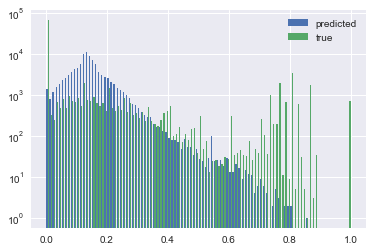

In [18]:
ax = plt.hist((model.predict(X_test), y_test), log=True, bins=100);
print(model.predict(X_test).mean())
print(y_test.mean())
plt.legend(labels=['predicted', 'true'])

In [19]:
for i in range(N_COMPONENTS):
    all_train['group{}'.format(i+1)] = pd.qcut(all_train['PCA-{}'.format(i+1)], q=100)

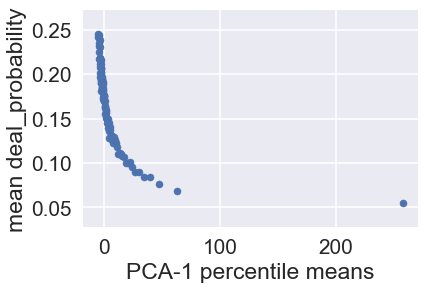

In [20]:
PCA_NUMBER = 1
sns.set_context("poster", font_scale=1.3)
all_train.groupby('group{}'.format(PCA_NUMBER)).mean().reset_index().plot(
    kind='scatter', x='PCA-{}'.format(PCA_NUMBER), y='deal_probability', s=50);
plt.xlabel('PCA-{} percentile means'.format(PCA_NUMBER));
plt.ylabel('mean deal_probability');
plt.savefig('PCA-{}.png'.format(PCA_NUMBER), bbox_inches='tight')

## Train a secondary model to learn PCA-1, etc features for the remaining users

In [21]:
train_pcas = pd.DataFrame()
train_pcas['user_id'] = periods_pcaed['user_id']
meta_target = []
for i in range(N_COMPONENTS):
    meta_target.append(list(periods_pcaed['PCA-{}'.format(i+1)].values))
train_pcas['pca_targets'] = list(zip(*meta_target))
train_pcas.head()

,user_id,pca_targets
0,00000077ff21,"(-1.8531663700284557, -3.46716036992249, -9.75..."
1,000006497719,"(-3.3193044553138944, 3.297781353985595, -6.16..."
2,00000b4d72f6,"(-4.90656834172024, 21.26017101521711, 2.42909..."
3,00000d642d7e,"(-2.2843116144915814, -2.00748581785741, 2.463..."
4,0000126b80a4,"(3.240861573633959, 8.357391994594222, -4.6017..."


In [22]:
train_pcas['pca_targets'][0]

(-1.8531663700284557, -3.46716036992249, -9.751790191086595, 5.434449905823733)

In [23]:
all_samples_user = all_samples.set_index('user_id').sort_values(by='activation_date').drop(['item_id', 'activation_date'], axis=1)

In [24]:
for feat in ['region', 'city', 'parent_category_name', 'category_name', 'user_type']:
    all_samples_user[feat] = all_samples_user[feat].astype('category').cat.codes

In [25]:
all_samples_user.head()

,region,city,parent_category_name,category_name,user_type,price_norm
user_id,,,,,,
1b48714c40c5,13,1133,2,4,0,-0.308250
1d4842a5fcf7,1,1634,1,28,2,0.471035
1f35fbd2efcb,21,996,4,10,1,0.101002
450858826d03,10,766,4,29,1,0.180346
1effdc345faf,6,576,5,15,0,0.430386


In [26]:
train_pcas = train_pcas.merge(all_samples_user.reset_index(), on='user_id', how='left').drop_duplicates('user_id').set_index('user_id')

In [27]:
target = 'pca_targets'
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(train_pcas.drop(target, axis=1).values, train_pcas[target].tolist(), random_state=SEED)

In [28]:
model_pca = RandomForestRegressor(n_estimators=30, random_state=SEED)
multi_target_model_pca = MultiOutputRegressor(model_pca)

In [29]:
multi_target_model_pca.fit(X_train_pca, y_train_pca)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=13, verbose=0, warm_start=False),
           n_jobs=1)

## Fill out the missing user info (in both train and test) by the secondary trained model

In [30]:
train_final = train.merge(train_pcas.reset_index(), how='left', on='user_id')

In [31]:
train_null = train_final[train_final['pca_targets'].isna()][['user_id']]

In [32]:
train_null = train_null.merge(all_samples_user.reset_index(), how='left', on='user_id')

In [33]:
train_null = train_null.drop_duplicates('user_id').set_index('user_id')

In [34]:
targets = multi_target_model_pca.predict(train_null.values)

In [35]:
for i in range(N_COMPONENTS):
    train_null['PCA-{}'.format(i+1)] = [t[i] for t in targets]

In [36]:
train_final = pd.concat([train_null[['PCA-{}'.format(i+1) for i in range(N_COMPONENTS)]], all_train.drop('deal_probability', axis=1)]).reset_index()

In [37]:
train_final = train[['user_id', 'item_id', 'deal_probability']].merge(train_final, how='left', on='user_id')

In [38]:
len(train_final)

1503424

In [39]:
test_pcas = periods_pcaed.copy()

In [40]:
test_pcas = test_pcas.merge(all_samples_user.reset_index(), on='user_id', how='left').drop_duplicates('user_id').set_index('user_id')
test_pcas.head()

,PCA-1,PCA-2,PCA-3,PCA-4,region,city,parent_category_name,category_name,user_type,price_norm
user_id,,,,,,,,,,
00000077ff21,-1.853166,-3.467160,-9.751790,5.434450,13,1133,0,41,1,0.429863
000006497719,-3.319304,3.297781,-6.165325,-6.646955,9,1427,5,15,1,0.443040
00000b4d72f6,-4.906568,21.260171,2.429095,9.622976,21,510,6,0,1,-0.374357
00000d642d7e,-2.284312,-2.007486,2.463280,-11.163899,17,1337,7,34,1,1.075971
0000126b80a4,3.240862,8.357392,-4.601765,0.917920,6,576,4,21,1,-0.906617


In [41]:
test_final = test.merge(test_pcas.reset_index(), how='left', on='user_id')

In [42]:
test_null = test_final[test_final['PCA-1'].isna()][['user_id']]

In [43]:
test_null = test_null.merge(all_samples_user.reset_index(), how='left', on='user_id')

In [44]:
test_null = test_null.drop_duplicates('user_id').set_index('user_id')

In [45]:
targets = multi_target_model_pca.predict(test_null.values)

In [46]:
for i in range(N_COMPONENTS):
    test_null['PCA-{}'.format(i+1)] = [t[i] for t in targets]

In [47]:
test_final = pd.concat([test_null[['PCA-{}'.format(i+1) for i in range(N_COMPONENTS)]], periods_pcaed.set_index('user_id')]).reset_index()

In [48]:
test_final = test[['user_id', 'item_id']].merge(test_final, how='left', on='user_id')

## Doing a final prediction for both train and test

In [49]:
train_final['deal_probability'] = model.predict(train_final.drop(['user_id', 'deal_probability'], axis=1).set_index('item_id').values)

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

In [ ]:
train_final.set_index('item_id').to_csv('data/train_periods_PCAs.csv')

In [ ]:
train_final.set_index('item_id')[['deal_probability']].to_csv('predictions/periods_train.csv')

In [ ]:
ax = plt.hist((train_final['deal_probability'], train['deal_probability']), log=True, bins=50);
plt.legend(labels=['predicted', 'true']);

In [ ]:
test_final['deal_probability'] = model.predict(test_final.drop(['user_id'], axis=1).set_index('item_id').values)

In [ ]:
test_final.set_index('item_id')[['deal_probability']].to_csv('predictions/periods.csv')

In [ ]:
test_final.set_index('item_id').to_csv('data/test_periods_PCAs.csv')

## Save the models

In [ ]:
import pickle
pickle.dump(model, open('saved_models/periods_rf.pickle', 'wb'))
pickle.dump(multi_target_model_pca, open('saved_models/periods_PCAs.pickle', 'wb'))

## Load the models

In [ ]:
# import pickle
# model = pickle.load(open('saved_models/periods_rf.pickle', 'rb'))
# multi_target_model_pca = pickle.load(open('saved_models/periods_PCAs.pickle', 'rb'))